In [1]:
import json
from texttable import Texttable
import latextable
from tabulate import tabulate
import sys
file_directory = "../"
sys.path.append(file_directory)
from generateDataset import generateDatasetFromResults
from metric import internalResultConsistency, calculatePercentageReductionSeries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import statistics

In [2]:
shapeIndexPathResult = "../results/standard/shape_index_result.json"
shapeIndexPathSummary = "../results/standard/summary_shape_index_result.json"
shapeIndexDataset = generateDatasetFromResults(shapeIndexPathResult, shapeIndexPathSummary, "shape index entries 100%")

In [3]:
shapeIndex20PathResult = "../results/shape-entry-20-percent/shape_index_result.json"
shapeIndex20PathSummary = "../results/shape-entry-20-percent/summary_shape_index_result.json"
shapeIndex20Dataset = generateDatasetFromResults(shapeIndex20PathResult, shapeIndex20PathSummary, "shape index entries 20%")

In [4]:
shapeIndex50PathResult = "../results/shape-entry-50-percent/shape_index_result.json"
shapeIndex50PathSummary = "../results/shape-entry-50-percent/summary_shape_index_result.json"
shapeIndex50Dataset = generateDatasetFromResults(shapeIndex50PathResult, shapeIndex50PathSummary, "shape index entries 50%")

In [5]:
shapeIndex80PathResult = "../results/shape-entry-80-percent/shape_index_result.json"
shapeIndex80PathSummary = "../results/shape-entry-80-percent/summary_shape_index_result.json"
shapeIndex80Dataset = generateDatasetFromResults(shapeIndex80PathResult, shapeIndex80PathSummary, "shape index entries 80%")

In [6]:
evalInstances = [shapeIndexDataset, shapeIndex20Dataset, shapeIndex50Dataset, shapeIndex80Dataset]

In [7]:
def colorViolon(part, color):  
    for pc in part['bodies']:
        pc.set_color(color)
        pc.set_edgecolor(color)
        pc.set_edgecolor(color)
        pc.set_alpha(0.75)
    part['cmeans'].set_color('black')
    part['cmins'].set_color('black')
    part['cmaxes'].set_color('black')
    part['cbars'].set_color('black')
    part['cmedians'].set_color('black')
    
color_map = {
    "shape index entries 100%": '#1A85FF',
    "shape index entries 0%": '#D41159',
    "shape index entries 20%": '#004D40',
    "shape index entries 50%": '#FFC107',
    "shape index entries 80%": '#994F00'
}


def plotOneQueryExecutionTime(instances, queryName, color_map):
    
    query_map = {
        "interactive-discover-1": "D1",
        "interactive-discover-2": "D2",
        "interactive-discover-3": "D3",
        "interactive-discover-4": "D4",
        "interactive-discover-5": "D5",
        "interactive-discover-6": "D6",
        "interactive-discover-7": "D7",
        "interactive-discover-8": "D8",
        "interactive-short-1": "S1",
        "interactive-short-2": "S2",
        "interactive-short-3": "S3",
        "interactive-short-4": "S4",
        "interactive-short-5": "S5",
        "interactive-short-6": "S6",
        "interactive-short-7": "S7"
    }
    
    indexes = np.linspace(0, 0.25, 5)
    #yaxisIndexes = np.arange(0, 2500, 500)
    
    width = 0.05 
    
    fig, ax = plt.subplots(figsize=(10, 8))
    #ax.set_yticks(yaxisIndexes)
    ax.set_xticks(indexes)
    ax.set_xticklabels(["{}V{}".format(query_map[queryName],i) for i,v in enumerate(indexes)])
    
    violon_plots = {}
    for instance in evalInstances:
        all_data= [data if data is not None else [0,0,0,0,0] for label,data in instance.executionTime[queryName].items()]
        current_plot = ax.violinplot(all_data, indexes, widths=width, showmeans=True, showmedians=True)
        violon_plots[instance.name] = current_plot
    
    
    ax.set_xlabel("Query")
    ax.set_ylabel("Execution time (ms)")
    ax.grid(axis="both")

    legend_elements = []
    
    for label, plot in violon_plots.items():
        color = color_map[label]
        colorViolon(plot,color)
        legend_elements.append(Line2D([0], [0], color=color, label=label))
    ax.legend(handles=legend_elements)

## Single plots

### Discover

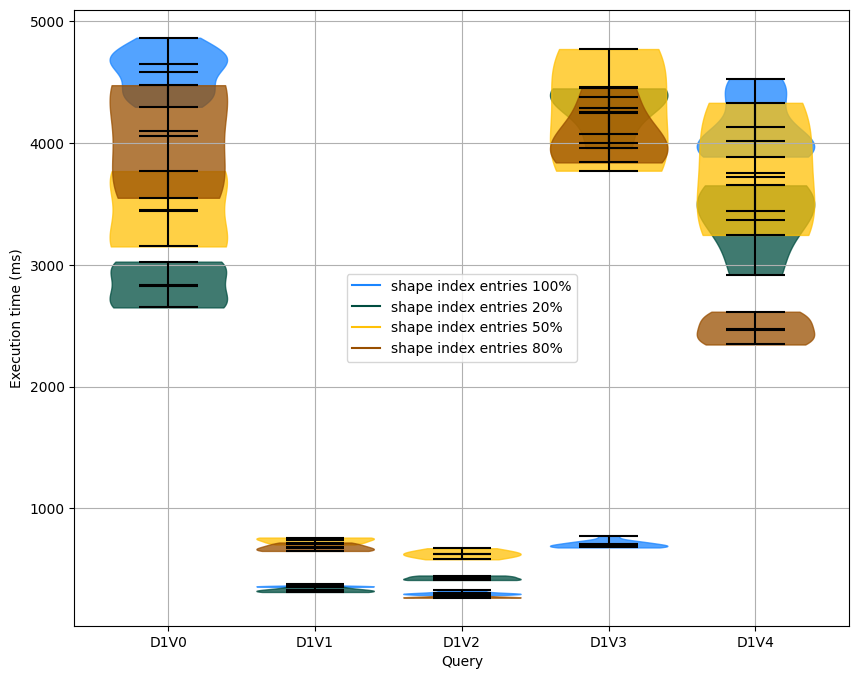

In [8]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-1", color_map)

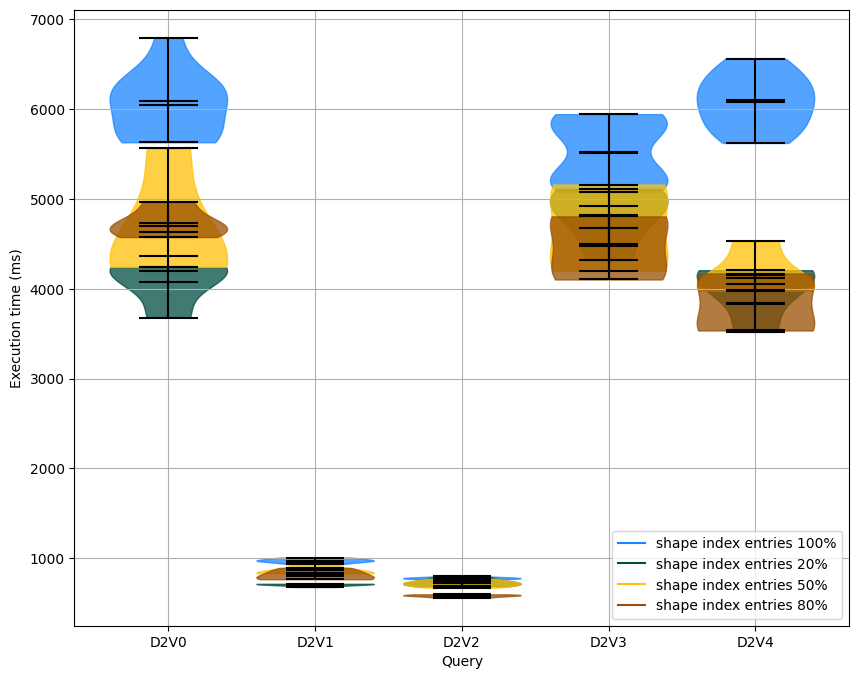

In [9]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-2", color_map)

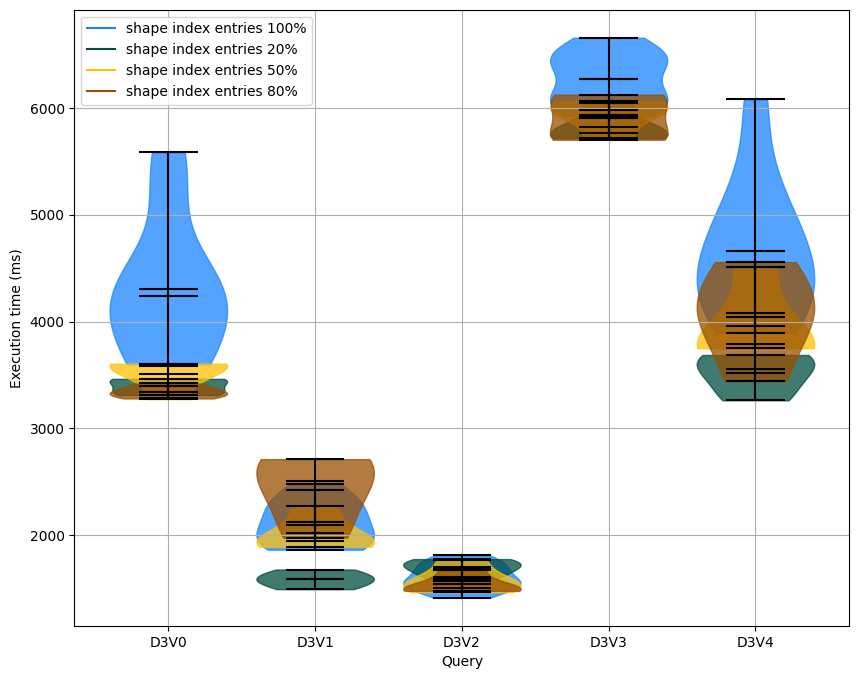

In [10]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-3", color_map)

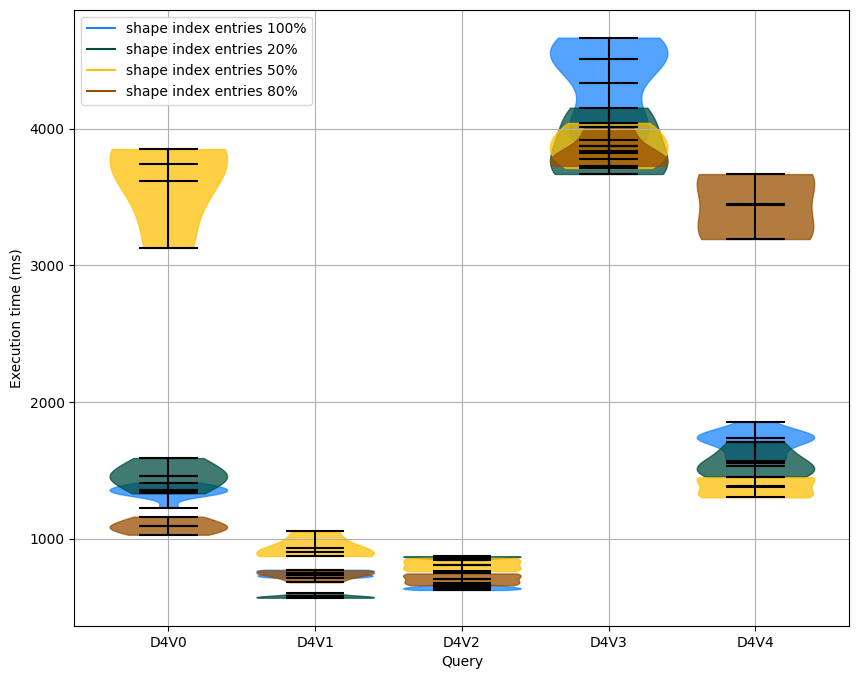

In [11]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-4", color_map)

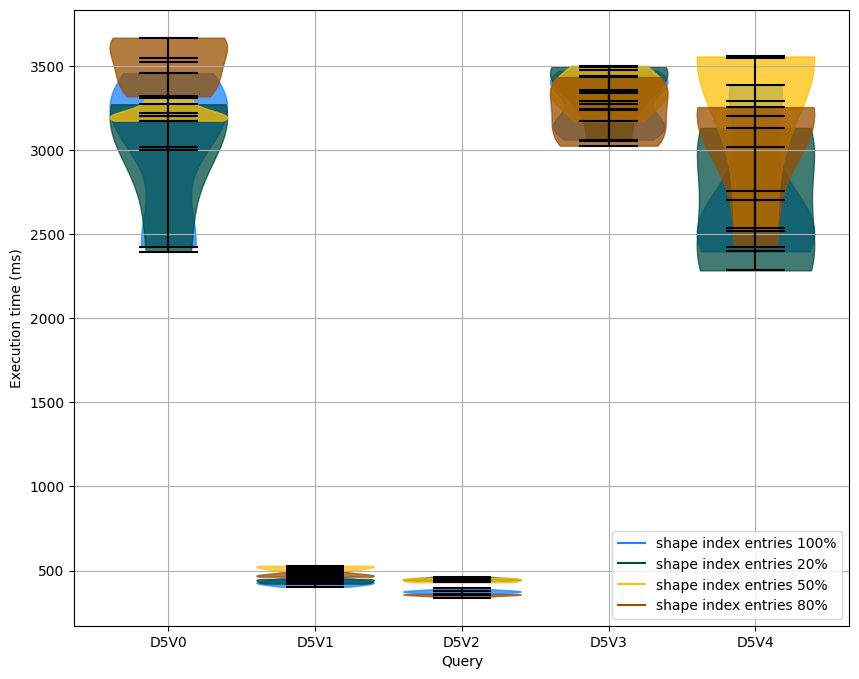

In [12]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-5", color_map)

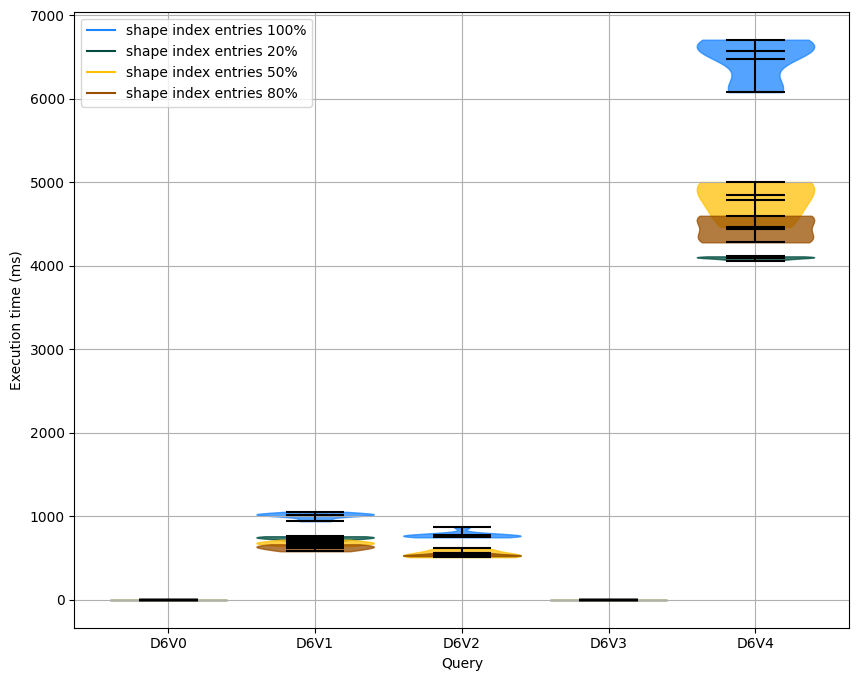

In [13]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-6", color_map)

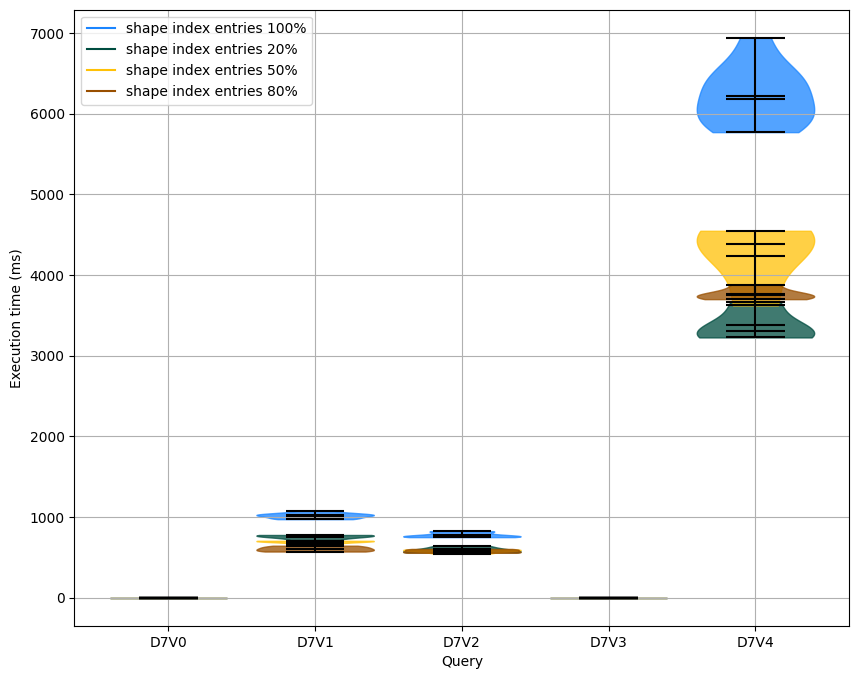

In [14]:
plotOneQueryExecutionTime(evalInstances,"interactive-discover-7", color_map)

### Short

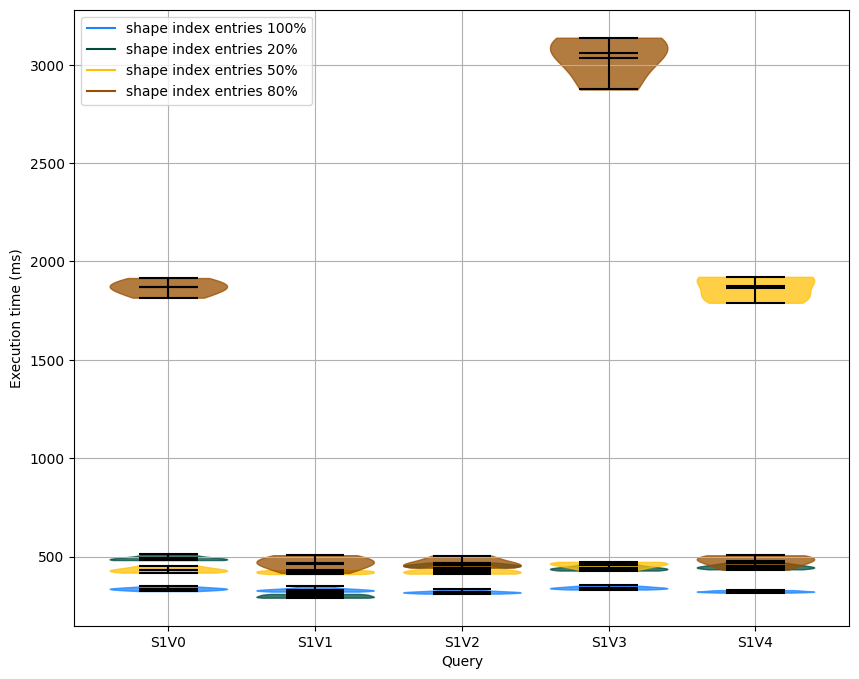

In [15]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-1", color_map)

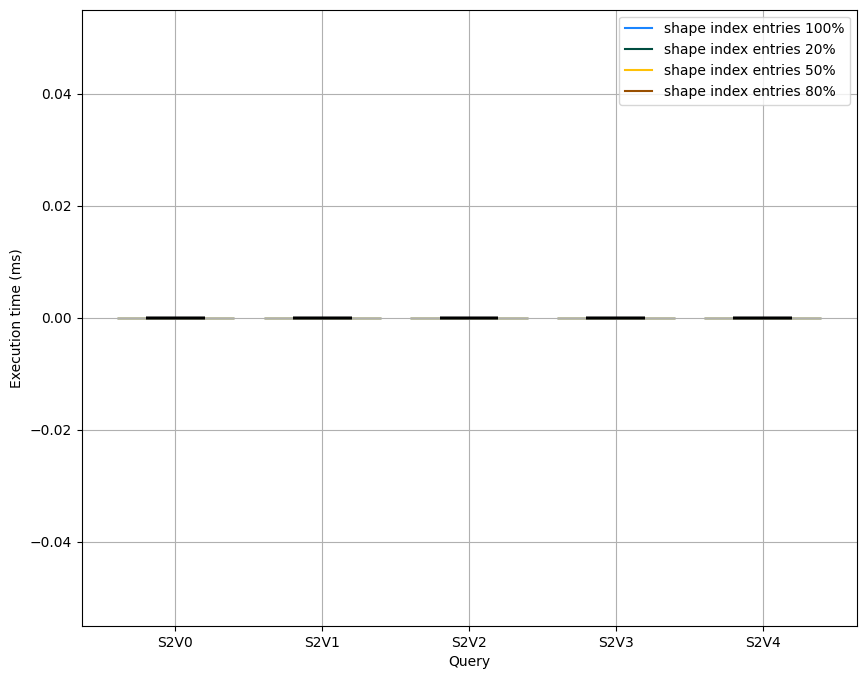

In [16]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-2", color_map)

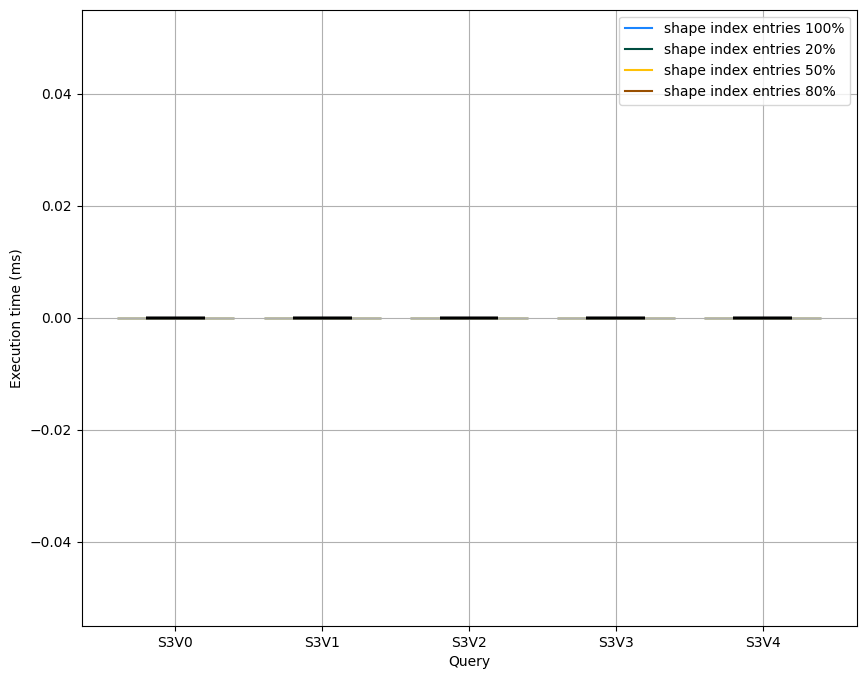

In [17]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-3", color_map)

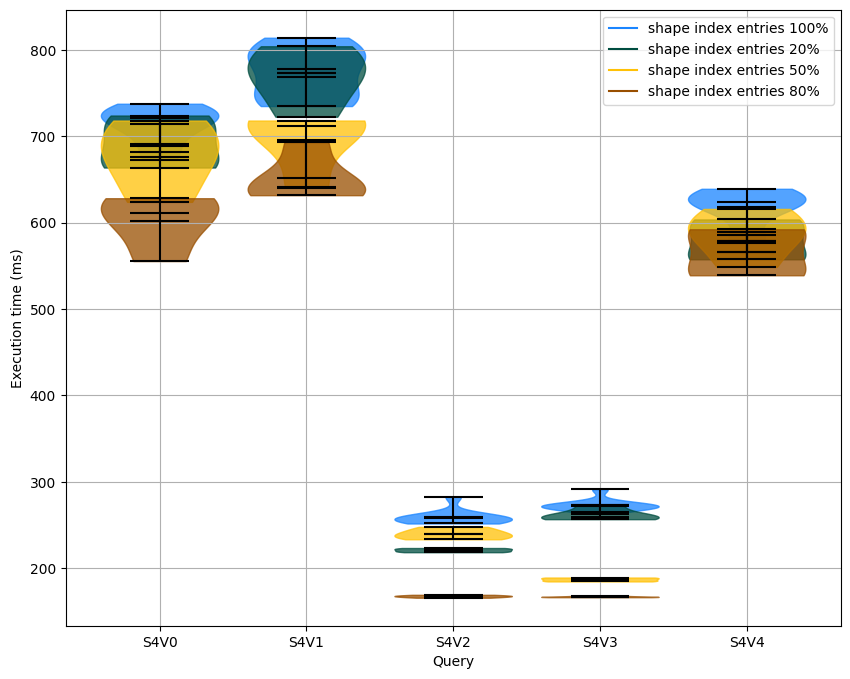

In [18]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-4", color_map)

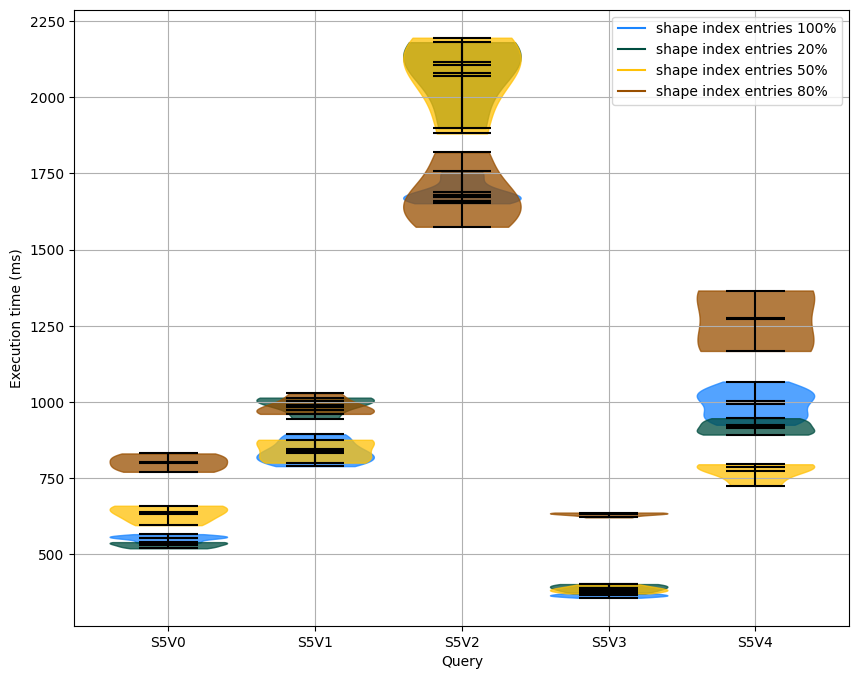

In [19]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-5", color_map)

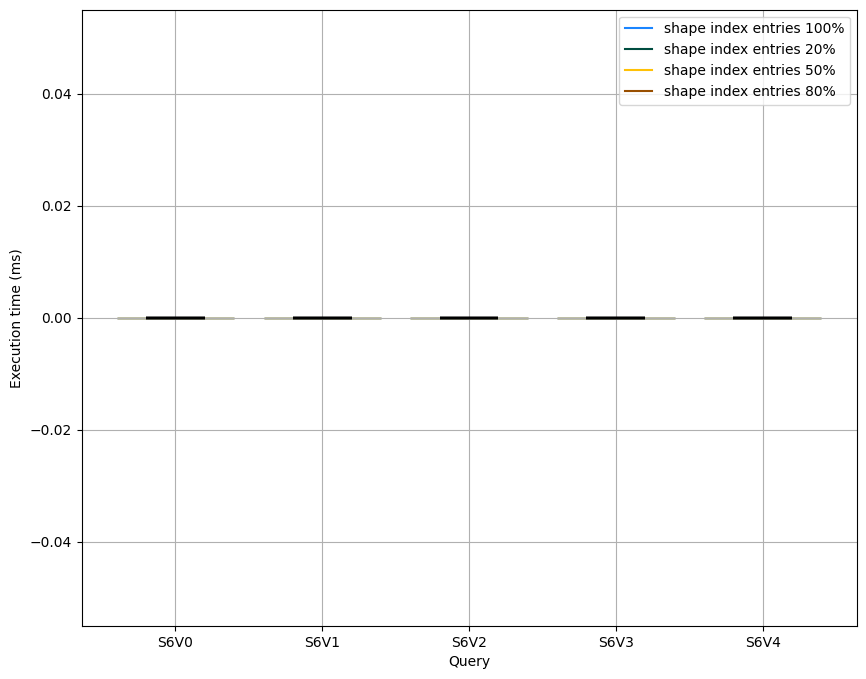

In [20]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-6", color_map)

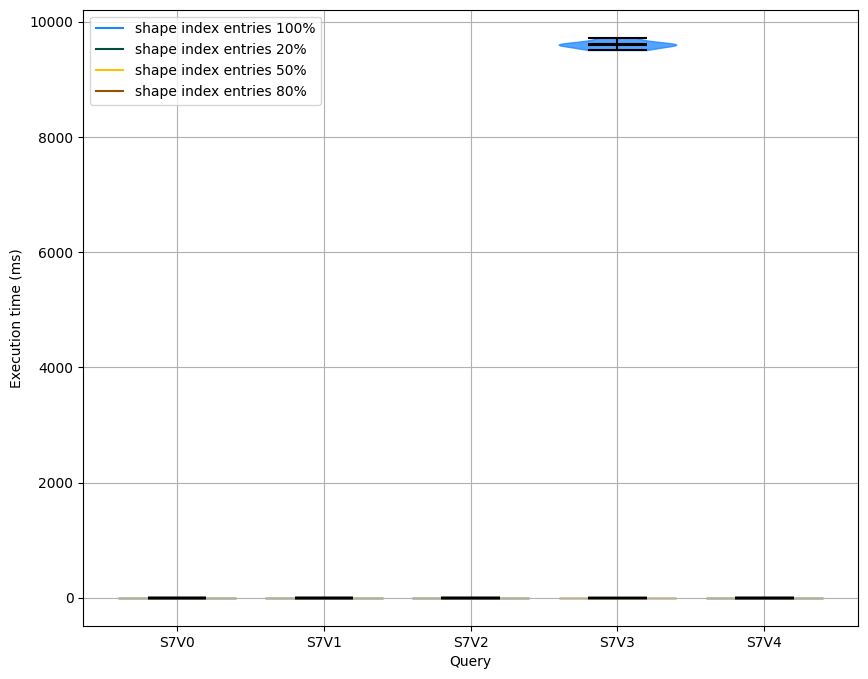

In [21]:
plotOneQueryExecutionTime(evalInstances,"interactive-short-7", color_map)

# Reduction by query templates

In [22]:
def statisticTemplateMetric(serie):
    stat = {}
    for query_template, val in serie.items():
        clean_list = list(filter(lambda a: a != None, val))
        avg = np.nan
        std = np.nan
        min_val = np.nan
        max_val = np.nan
        if len(clean_list) !=0:
            avg = statistics.mean(clean_list)
            if len(clean_list) > 2:
                std = statistics.stdev(clean_list)
            min_val = min(clean_list)
            max_val = max(clean_list)
        stat[query_template] = {
            "avg": avg,
            "std": std,
            "min":min_val,
            "max": max_val,
            "raw": list(map(lambda x: x if x != None else np.nan, val))
        }
    return stat

In [23]:
result_object = {}

In [24]:
instances = [ shapeIndex20Dataset, shapeIndex50Dataset, shapeIndex80Dataset]
for instance in instances:
    reduction_http_req = calculatePercentageReductionSeries(instance.numberHttpRequest, shapeIndexDataset.numberHttpRequest)
    reduction_time = calculatePercentageReductionSeries(instance.meanExecutionTime, shapeIndexDataset.meanExecutionTime)
    
    stat_http_req = statisticTemplateMetric(reduction_http_req)
    stat_time = statisticTemplateMetric(reduction_time)
    
    result_object[instance.name] = {
        "http_request": stat_http_req,
        "time": stat_time
    }

# Reduction by query templates figure

In [25]:
result_object_means_http = {}
result_object_http = {}
result_object_means_time = {}
result_object_time = {}

for instance, results in result_object.items():
    result_object_means_http[instance] = []
    result_object_means_time[instance] = []

    result_object_http[instance] = []
    result_object_time[instance] = []
    for key, values in results.items():
        if key=="time":
            for value in values.values():
                result_object_means_time[instance].append(value['avg'])
                result_object_time[instance].append(value['raw'])
                
        if key=="http_request":
            for value in values.values():
                result_object_means_http[instance].append(value['avg'])
                result_object_http[instance].append(value['raw'])
    

In [26]:
query_map = {
        "interactive-discover-1": "D1",
        "interactive-discover-2": "D2",
        "interactive-discover-3": "D3",
        "interactive-discover-4": "D4",
        "interactive-discover-5": "D5",
        "interactive-discover-6": "D6",
        "interactive-discover-7": "D7",
        "interactive-discover-8": "D8",
        "interactive-short-1": "S1",
        "interactive-short-2": "S2",
        "interactive-short-3": "S3",
        "interactive-short-4": "S4",
        "interactive-short-5": "S5",
        "interactive-short-6": "S6",
        "interactive-short-7": "S7"
    }

queries = query_map.values()

In [27]:
rcParams.update({'font.size': 13})

def generatePlot(results, yaxisLabel):
    
    x = np.arange(len(queries))
    width = 1/len(instances) -0.1 # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(10, 8))

    for dataset, measurements in results.items():
        offset = width * multiplier + width/len(results)
        data = list(range(len(queries)))
        for i, measurement in enumerate(measurements):
            data[i] = measurement
        multiplier += 1
        ax.boxplot(data,
                   positions=x+offset,
                   widths=width,
                   patch_artist=True,
                   label=dataset,
                   boxprops=dict(facecolor=color_map[dataset]),
                  )
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.set_ylabel(yaxisLabel)
    ax.set_xticks(x + width, queries)
    ax.grid(axis="both")
    ax.legend()

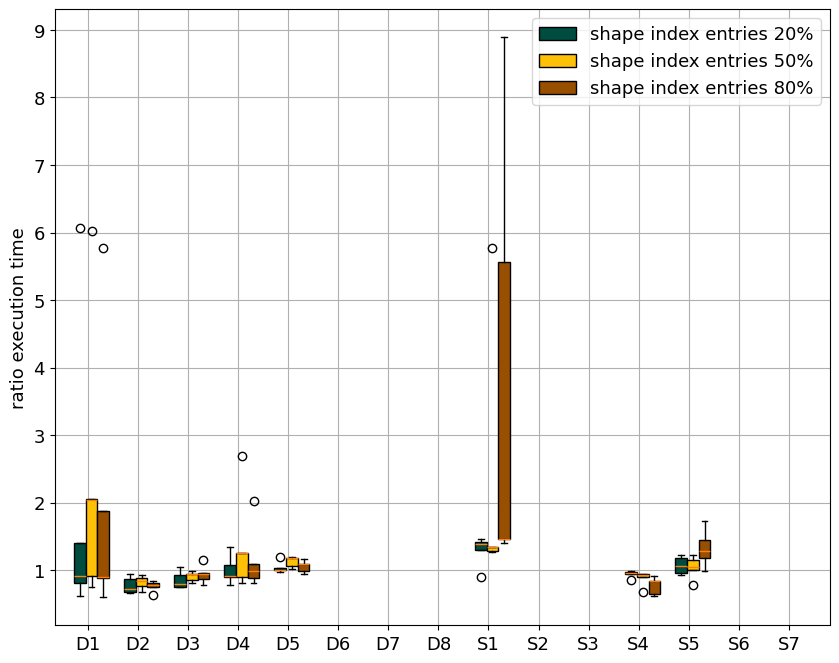

In [28]:
generatePlot(result_object_time,'ratio execution time')

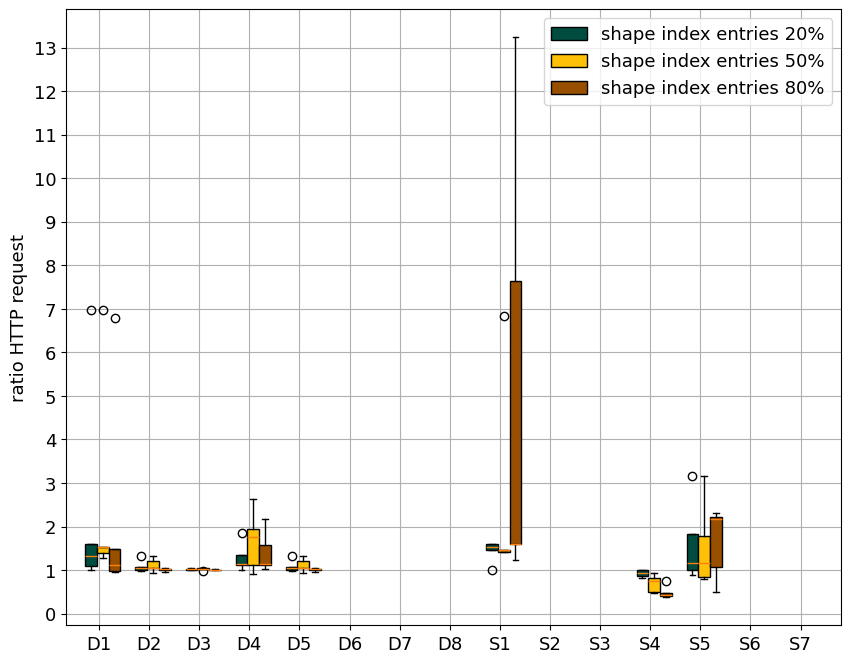

In [29]:
generatePlot(result_object_http,'ratio HTTP request')